In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
train.shape

(27481, 4)

In [5]:
train[train.text.isnull()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [6]:
#remove nan entries
train = train[train.text.isnull()==False].reset_index()

In [7]:
train.shape

(27480, 5)

In [8]:
%matplotlib inline

In [9]:
from matplotlib import pyplot as plt

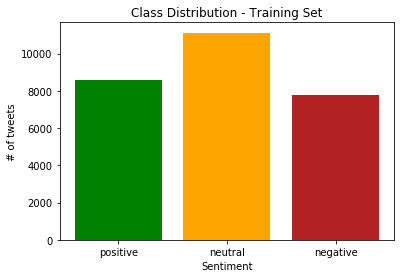

In [10]:
plt.bar(x=[0,1,2], height=[len(train[train.sentiment=='positive']),len(train[train.sentiment=='neutral']),len(train[train.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Training Set')
plt.show()

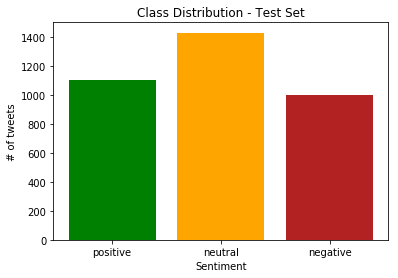

In [11]:
plt.bar(x=[0,1,2], height=[len(test[test.sentiment=='positive']),len(test[test.sentiment=='neutral']),len(test[test.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Test Set')
plt.show()

**Bag of words**

In [ ]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(lowercase=True, stop_words='english') #  exclude common words in English
count_vector.fit(train['text'].get_values())

In [ ]:
#transform train to bag of words matrix
words_array = count_vector.transform(train['text']).toarray()
words_matrix =  pd.DataFrame(words_array, columns = count_vector.get_feature_names())

Count number of samples that contain each word in entire training dataset and in positive and negative samples seperately:

In [ ]:
total_freq = words_matrix.astype(bool).sum(axis=0).sort_values(ascending=False)

In [ ]:
#add label column to word_matrix
words_matrix['sentiment'] = train.sentiment

In [ ]:
positive_freq = words_matrix[words_matrix.sentiment == 'positive'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)
negative_freq = words_matrix[words_matrix.sentiment == 'negative'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)

In [ ]:
words_stats = pd.concat([total_freq, positive_freq.reindex(total_freq.index), negative_freq.reindex(total_freq.index)], axis=1)
words_stats = words_stats.rename(columns={0: 'total_count', 1: 'pos_count', 2: 'neg_count'})

In [ ]:
words_stats.head(25)

In [ ]:
words_stats.loc['awesome']

Remove common words that appear in both pos and neg classes with a similar frequency (or with a high frequency in neutral sentiment records):

In [ ]:
#calculate percentage of phrases that contain each word that have pos or neg sentiment
words_stats['pos_pct'] = words_stats['pos_count']/words_stats['total_count']
words_stats['neg_pct'] = words_stats['neg_count']/words_stats['total_count']

In [ ]:
#remove words that do not have a particular class (pos or neg) mainly associated with them
thres_pct = 0.5
words_stats_reduced = words_stats[(words_stats.pos_pct>=thres_pct)|(words_stats.neg_pct>=thres_pct)]

In [ ]:
words_stats_reduced.head()

Top words associated with positive sentiment:

In [ ]:
words_stats_reduced[words_stats_reduced.pos_pct>words_stats_reduced.neg_pct].head(10)

In [ ]:
#save all words that appear frequently in positive tweets
pos_words = words_stats_reduced[words_stats_reduced.pos_pct>words_stats_reduced.neg_pct].index.values

Top words associated with negative sentiment:

In [ ]:
words_stats_reduced[words_stats_reduced.pos_pct<words_stats_reduced.neg_pct].head(10)

In [ ]:
#save all words that appear frequently in negative tweets
neg_words = words_stats_reduced[words_stats_reduced.pos_pct<words_stats_reduced.neg_pct].index.values

**Baseline model**

We will first test a simple model which is based on the balance between the count of words that are commonly encountered in positive sentiment tweets and words commonly used in negative sentiment tweets. If a given tweet contains more 'positive' words than 'negative' words it is classified as positive while if it contains more 'negative' words it is classified as negative. If there is the same number of 'positive' and 'negative' words (or the difference between the two counts is not greater than a pre-defined limit) then the tweet is classified as 'neutral'.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def baseline_classifier(matrix, pos_words, neg_words, limit=0):
    words_balance = pd.DataFrame(matrix[pos_words].sum(axis=1)-matrix[neg_words].sum(axis=1)).rename(columns={0:'balance'})
    words_balance['sentiment'] = words_balance.balance.apply(lambda x: 'positive' if x>limit else ('negative' if x<-limit else 'neutral'))
    return words_balance['sentiment'].values

Run on training set with lim=0 (i.e. if n_pos>n_neg then 'positive'):

In [ ]:
train_pred = baseline_classifier(words_matrix,pos_words,neg_words,limit=0)

In [ ]:
print('Results on training set:')
print('Accuracy score: ', format(accuracy_score(train.sentiment.values, train_pred)))
print('Precision score: ', format(precision_score(train.sentiment.values, train_pred,average=None)))
print('Recall score: ', format(recall_score(train.sentiment.values, train_pred,average=None)))
print('F1 score: ', format(f1_score(train.sentiment.values, train_pred,average=None)))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(train.sentiment.values, train_pred, ['positive','neutral','negative'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['positive','neutral','negative'])
ax.yaxis.set_ticklabels(['positive','neutral','negative'])
plt.show()

Run on training set with lim=1 (i.e. if n_pos-n_neg>1 then 'positive'):

In [ ]:
train_pred = baseline_classifier(words_matrix,pos_words,neg_words,limit=1)

In [ ]:
print('Results on training set:')
print('Accuracy score: ', format(accuracy_score(train.sentiment.values, train_pred)))
print('Precision score: ', format(precision_score(train.sentiment.values, train_pred,average=None)))
print('Recall score: ', format(recall_score(train.sentiment.values, train_pred,average=None)))
print('F1 score: ', format(f1_score(train.sentiment.values, train_pred,average=None)))

While recall improves for 'neutral' when lim>0, it significantly drops for 'positive' and 'negative' tweets.

Run on test set with lim=0:

In [ ]:
#transform test to bag of words matrix, using count vectorizer fitted to train data
test_array = count_vector.transform(test['text']).toarray()
test_matrix =  pd.DataFrame(test_array, columns = count_vector.get_feature_names())

In [ ]:
test_pred = baseline_classifier(test_matrix,pos_words,neg_words,limit=0)

In [ ]:
print('Results on test set:')
print('Accuracy score: ', format(accuracy_score(test.sentiment.values, test_pred)))
print('Precision score: ', format(precision_score(test.sentiment.values, test_pred,average=None)))
print('Recall score: ', format(recall_score(test.sentiment.values, test_pred,average=None)))
print('F1 score: ', format(f1_score(test.sentiment.values, test_pred,average=None)))

In [ ]:
cm = confusion_matrix(test.sentiment.values, test_pred, ['positive','neutral','negative'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['positive','neutral','negative'])
ax.yaxis.set_ticklabels(['positive','neutral','negative'])
plt.show()

**Naive Bayes Model**

In [12]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector.fit(train['text'].get_values())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [13]:
#transform train to bag of words matrix
words_array = count_vector.transform(train['text']).toarray()
words_matrix =  pd.DataFrame(words_array, columns = count_vector.get_feature_names())
train_matrix = np.array(words_matrix)

Fix words with repeated letters (e.g. 'loooveee' becomes 'love' and 'gooood' becomes 'good'):

In [15]:
import re
all_words = words_matrix.columns.values
word_dict = {}
for word in all_words:
    word_a = re.sub(r'(.)\1+', r'\1', word)
    word_b = re.sub(r'(.)\1+', r'\1\1', word)
    
    count_ = words_matrix.word.sum(axis=0)
    count_a = words_matrix[word_a].sum(axis=0) if word_a in all_words else 0
    count_b = words_matrix[word_b].sum(axis=0) if word_b in all_words else 0
    
    if count_ < count_a and count_a > count_b:
        word_dict[word] = word_a
    elif count_ < count_b and count_b > count_a:
        word_dict[word] =  word_b
    else:
        word_dict[word] = word

In [16]:
word_dict['gooood']

'good'

In [17]:
word_dict['loveee']

'love'

In [18]:
def remove_repeated_chars(sentence, word_dict):
    translated = []
    for x in list(sentence.split()):
        t = word_dict.get(x, x) 
        translated.append(t)
    newphrase = ' '.join(translated)
    return newphrase

In [19]:
#store copy of training set text field with no repeating characters
train_text_norm = train.text.apply(lambda x: remove_repeated_chars(x,word_dict))

In [22]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector_2 = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector_2.fit(train_text_norm.get_values())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [23]:
#transform train to bag of words matrix
words_array_2 = count_vector_2.transform(train_text_norm).toarray()
words_matrix_2 =  pd.DataFrame(words_array_2, columns = count_vector_2.get_feature_names())
train_matrix_2 = np.array(words_matrix_2)

In [28]:
words_matrix_2['goood'].sum(axis=0) #need to fix

5

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train.sentiment.astype(str))
train_labels = le.transform(train.sentiment.astype(str))

In [41]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(train_matrix, train_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
train_pred = naive_bayes.predict(train_matrix)
train_pred = le.inverse_transform(train_pred)

In [44]:
print('Results on training set:')
print('Accuracy score: ', format(accuracy_score(train.sentiment.values, train_pred)))
print('Precision score: ', format(precision_score(train.sentiment.values, train_pred,average=None)))
print('Recall score: ', format(recall_score(train.sentiment.values, train_pred,average=None)))
print('F1 score: ', format(f1_score(train.sentiment.values, train_pred,average=None)))

Results on training set:
Accuracy score:  0.8403566229985444
Precision score:  [0.87026422 0.8104825  0.85645821]
Recall score:  [0.8000257  0.85823514 0.85376369]
F1 score:  [0.83366814 0.83367556 0.85510883]


In [45]:
#transform test to bag of words matrix, using count vectorizer fitted to train data
test_array = count_vector.transform(test['text']).toarray()
test_matrix =  pd.DataFrame(test_array, columns = count_vector.get_feature_names())

In [46]:
test_pred = naive_bayes.predict(test_matrix) 
test_pred = le.inverse_transform(test_pred)

In [47]:
print('Results on test set:')
print('Accuracy score: ', format(accuracy_score(test.sentiment.values, test_pred)))
print('Precision score: ', format(precision_score(test.sentiment.values, test_pred,average=None)))
print('Recall score: ', format(recall_score(test.sentiment.values, test_pred,average=None)))
print('F1 score: ', format(f1_score(test.sentiment.values, test_pred,average=None)))

Results on test set:
Accuracy score:  0.655631013016412
Precision score:  [0.67767654 0.59668508 0.73028238]
Recall score:  [0.59440559 0.67972028 0.67996374]
F1 score:  [0.63331559 0.6355018  0.70422535]


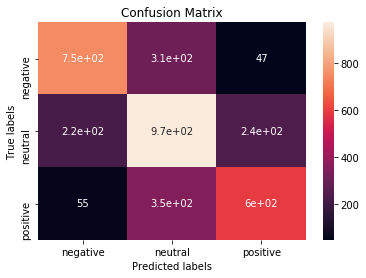

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test.sentiment.values, test_pred, ['positive','neutral','negative'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(le.inverse_transform([0,1,2]))
ax.yaxis.set_ticklabels(le.inverse_transform([0,1,2]))
plt.show()